In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Chest X-ray Pneumonia Detection using Classical Machine Learning

In [1]:
import os
import numpy as np
from PIL import Image
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


In [60]:
IMG_SIZE = (64, 64)
DATA_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# Load Dataset and Extract HOG Features

In [3]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpeg', '.jpg', '.png')):
            path = os.path.join(folder, filename)
            img = Image.open(path).convert('L')
            img = img.resize(IMG_SIZE)
            img_array = np.array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return images, labels


In [4]:
def load_dataset(base_path):
    X, y = [], []
    for category, label in [('NORMAL', 0), ('PNEUMONIA', 1)]:
        folder = os.path.join(base_path, category)
        images, labels = load_images_from_folder(folder, label)
        X.extend(images)
        y.extend(labels)
    return np.array(X), np.array(y)


In [5]:
# -------------------------
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

In [6]:
# Load and preprocess data
X_train_imgs, y_train = load_dataset(os.path.join(DATA_PATH, 'train'))
X_val_imgs, y_val = load_dataset(os.path.join(DATA_PATH, 'val'))
X_test_imgs, y_test = load_dataset(os.path.join(DATA_PATH, 'test'))

# See if there is an imbalance 

In [7]:
from collections import Counter

counter = Counter(y_train)
print(counter)

Counter({1: 3875, 0: 1341})


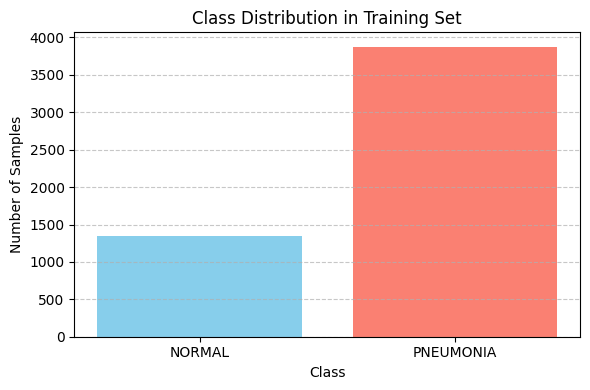

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Count samples per class
class_counts = Counter(y_train)

# Prepare data for plotting
labels = ['NORMAL', 'PNEUMONIA']
counts = [class_counts[0], class_counts[1]]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
!pip install -U scikit-learn imbalanced-learn

In [ ]:
!pip install --upgrade scikit-learn


In [11]:
from imblearn.over_sampling import SMOTE

In [13]:
# Extract HOG features
X_train_hog = extract_hog_features(X_train_imgs)
X_val_hog = extract_hog_features(X_val_imgs)
X_test_hog = extract_hog_features(X_test_imgs)

# Applying PCA for Dimensionality Reduction

In [14]:
# PCA for Dimensionality Reduction
# -------------------------
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca = pca.transform(X_val_hog)
X_test_pca = pca.transform(X_test_hog)


# Using SMOTE(Synthetic Minority Oversampling Technique)to oversample the minority class

In [ ]:
from imblearn.over_sampling import SMOTE


In [16]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)

# Confirm new class distribution
print("After SMOTE:", Counter(y_train_balanced))


After SMOTE: Counter({0: 3875, 1: 3875})


# Elbow Method to Find The Optimal Value for K

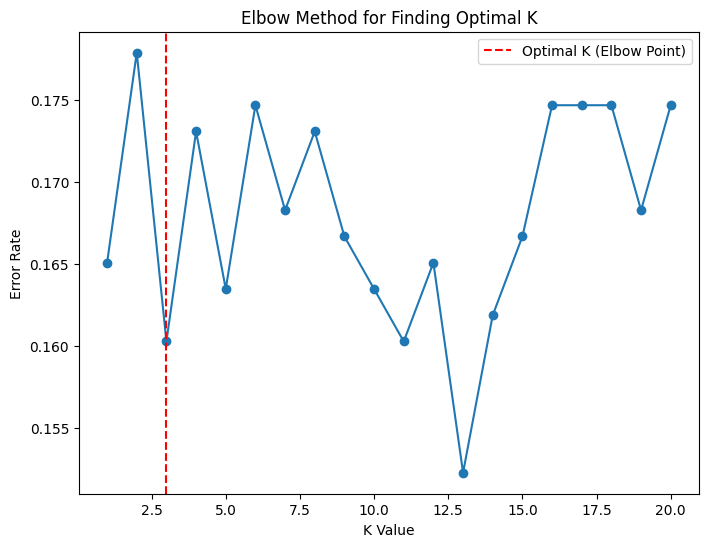

In [41]:
k_values = range(1, 21)
error_rates = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_balanced, y_train_balanced)
    y_pred = knn.predict(X_test_pca)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Finding Optimal K')
plt.axvline(x=3, linestyle='--', color='red', label="Optimal K (Elbow Point)")
plt.legend()
plt.show()

# Train KNN Model 

In [42]:
from sklearn.neighbors import KNeighborsClassifier

model_KNN = KNeighborsClassifier(n_neighbors=3)
model_KNN.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier(n_neighbors=3)

# Evaluate KNN

In [43]:
y_pred = model_KNN.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8397435897435898


              precision    recall  f1-score   support

           0       0.78      0.80      0.79       234
           1       0.88      0.86      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



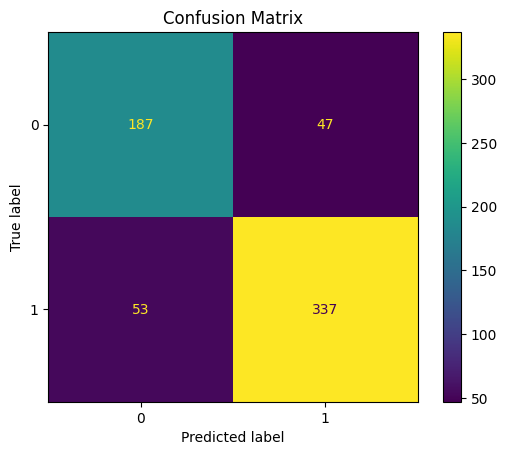

In [44]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

* Precision (Normal = 0.78): Of all predicted Normal cases, 78% were correct.

* Recall (Normal = 0.80): Of all actual Normal cases, 80% were detected.

* F1-score (Normal = 0.79): Balances precision and recall — moderate performance.

* Precision (Pneumonia = 0.88): Of all predicted Pneumonia, 88% were right.

* Recall (Pneumonia = 0.86): 86% of true pneumonia cases were correctly predicted.

* F1-score (Pneumonia = 0.87): Solid performance on this class.

# Predict a Singe Image using KNN 

In [45]:
def predict_single_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    
    # Extract HOG features
    features = hog(img_array, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    features_pca = pca.transform([features])
    
    prediction = model_KNN.predict(features_pca)[0]
    label = 'PNEUMONIA' if prediction == 1 else 'NORMAL'
    
    # Show image and prediction
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

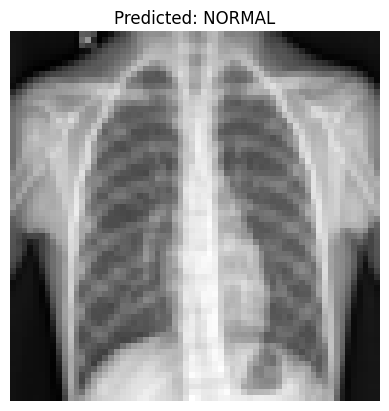

In [46]:
# Test on a single image
predict_single_image('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

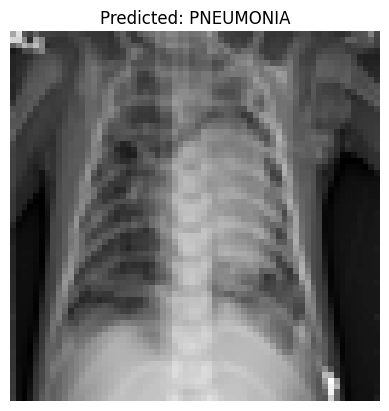

In [48]:
predict_single_image('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg')